<a href="https://colab.research.google.com/github/jingkloos/Machine-learning/blob/master/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation

This project is to recommend movies to users based on Spark ML. 
I used movielens dataset which has over 27 million ratings of 58 thousands of movies as my training dataset. Spark ALS was used to train the data. Spark ALS is a matrix factorization based recommender module. It can handle cold start situation and process implicit dataset. 

I used an explicit dataset (user-movie-ratings) in this project and cold start strategy is to drop unseen users/items which means the model was trained with all valid (non-null) data. Root mean square error of the best model on training data is 0.813, 0.814 on test data and 0.76 on all data.

Since it took long time to train the model, I saved the best model to disk as well as all the recommendations for each user so that I could use the pretrained model whenever I need to.

User defined function was created using the best trained model to generate recommended movies by passing a user id. It can be used as an API for any applications.

I also used the latent factor of items generated by the model to get similar movies.


## Spark Setup 

In [ ]:
# Set up Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirrors.hoobly.com/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME

     |████████████████████████████████| 204kB 3.4MB/s 
/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory



In [ ]:
!pip uninstall pyarrow -y
!pip install pyarrow
!pip install koalas
!pip install elasticsearch
!pip install tmdbsimple

Uninstalling pyarrow-0.14.1:
  Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 17.2MB 1.4MB/s 


     |████████████████████████████████| 1.1MB 3.5MB/s 
     |████████████████████████████████| 194kB 3.4MB/s 


In [ ]:

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"
import findspark
findspark.init("spark-3.0.0-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import databricks.koalas as ks
from pyspark.sql.functions import col,when
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.types import *
import pyspark.sql.functions as F
import re
import json
import warnings
import os
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls

drive  sample_data  spark-3.0.0-bin-hadoop2.7  spark-3.0.0-bin-hadoop2.7.tgz


In [ ]:
spark.version

'3.0.0'

## Load Data

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest.zip

--2020-07-28 19:53:32--  http://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip’

ml-latest.zip       100%[===================>] 264.28M   118MB/s    in 2.2s    

2020-07-28 19:53:34 (118 MB/s) - ‘ml-latest.zip’ saved [277113433/277113433]



In [ ]:
!ls

drive	       sample_data		  spark-3.0.0-bin-hadoop2.7.tgz
ml-latest.zip  spark-3.0.0-bin-hadoop2.7


In [ ]:
!unzip ml-latest.zip

Archive:  ml-latest.zip
   creating: ml-latest/
  inflating: ml-latest/links.csv     
  inflating: ml-latest/tags.csv      
  inflating: ml-latest/genome-tags.csv  
  inflating: ml-latest/ratings.csv   
  inflating: ml-latest/README.txt    
  inflating: ml-latest/genome-scores.csv  
  inflating: ml-latest/movies.csv    


In [ ]:
!ls ml-latest/

genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


In [ ]:
DATA_PATH='./ml-latest'
ratings_df = spark.read.csv(DATA_PATH+'/ratings.csv',inferSchema=True,header=True)
movies_df=spark.read.csv(DATA_PATH+'/movies.csv',inferSchema=True,header=True)
links_df=spark.read.csv(DATA_PATH+'/links.csv',inferSchema=True,header=True)
tags_df=spark.read.csv(DATA_PATH+'/tags.csv',inferSchema=True,header=True)
ratings_df.cache()


DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

In [ ]:
ratings_df.show(5,False)

+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |307    |3.5   |1256677221|
|1     |481    |3.5   |1256677456|
|1     |1091   |1.5   |1256677471|
|1     |1257   |4.5   |1256677460|
|1     |1449   |4.5   |1256677264|
+------+-------+------+----------+
only showing top 5 rows



In [ ]:
movies_df.show(5,truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [ ]:
links_df.show(5)

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
+-------+------+------+
only showing top 5 rows



In [ ]:
tags_df.show(5)

+------+-------+------------+----------+
|userId|movieId|         tag| timestamp|
+------+-------+------------+----------+
|    14|    110|        epic|1443148538|
|    14|    110|    Medieval|1443148532|
|    14|    260|      sci-fi|1442169410|
|    14|    260|space action|1442169421|
|    14|    318|imdb top 250|1442615195|
+------+-------+------------+----------+
only showing top 5 rows



## Explore Data

In [ ]:
dfs={'movies':movies_df,'ratings':ratings_df,'links':links_df,'tags':tags_df}
for i in dfs:
  dfs[i].registerTempTable(i)
  print('count of {}: {}'.format(i,dfs[i].count()))

count of movies: 58098
count of ratings: 27753444
count of links: 58098
count of tags: 1108997


### Ratings

In [ ]:
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [ ]:
movie_rating_ct=ratings_df.groupBy('movieId').count().toPandas()

In [ ]:
movie_rating_ct.sort_values(by='count',ascending=False,ignore_index=True,inplace=True)

In [ ]:
user_rating_ct=ratings_df.groupBy('userId').count().toPandas()
user_rating_ct.sort_values(by='count',ascending=False,ignore_index=True,inplace=True)

Text(0, 0.5, 'Number of ratings (log)')

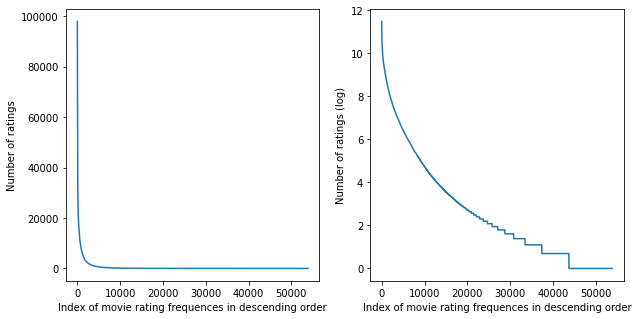

In [ ]:
#distribution
fig=plt.figure(figsize=[10,5])
fig.subplots_adjust(hspace=5)
ax1=fig.add_subplot(121)
ax1.plot(movie_rating_ct['count'])
ax1.set_xlabel('Index of movie rating frequences in descending order')
ax1.set_ylabel('Number of ratings')
ax2=fig.add_subplot(122)
ax2.plot(np.log(movie_rating_ct['count']))
ax2.set_xlabel('Index of movie rating frequences in descending order')
ax2.set_ylabel('Number of ratings (log)')
# this is a typical long tail distribution, only a few movies receive a lot of ratings

Text(0, 0.5, 'Number of ratings (log)')

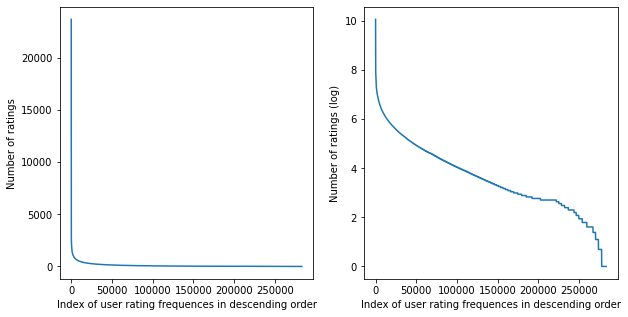

In [ ]:
#distribution
fig=plt.figure(figsize=[10,5])
fig.subplots_adjust(hspace=5)
ax1=fig.add_subplot(121)
ax1.plot(user_rating_ct['count'])
ax1.set_xlabel('Index of user rating frequences in descending order')
ax1.set_ylabel('Number of ratings')
ax2=fig.add_subplot(122)
ax2.plot(np.log(user_rating_ct['count']))
ax2.set_xlabel('Index of user rating frequences in descending order')
ax2.set_ylabel('Number of ratings (log)')
# this is a typical long tail distribution, only a few users give a lot of ratings

In [ ]:
#check null values for ratings
#count null for each columns
def count_null(col_name):
  return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

exprs=[count_null(col_name) for col_name in ratings_df.columns]

ratings_df.agg(*exprs).show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+



In [ ]:

# average rating of movies
avg_ratings=ratings_df.groupBy('movieId').agg(F.mean('rating')).toPandas()
avg_ratings.head()

,movieId,avg(rating)
0,1591,2.646666
1,1645,3.535294
2,471,3.652909
3,1088,3.248014
4,1580,3.578533


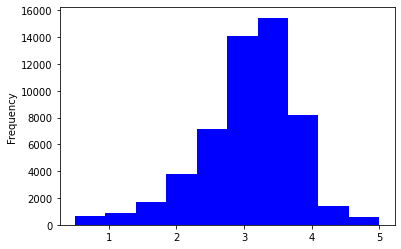

In [ ]:
avg_ratings['avg(rating)'].plot(kind='hist',color='blue')
plt.savefig('fig_2.png',dpi=600)

In [ ]:
# average rating per user
avg_ratings_user=ratings_df.groupBy('userId').agg(F.mean('rating')).toPandas()
avg_ratings_user.head()

,userId,avg(rating)
0,148,3.000000
1,463,2.108696
2,471,3.254821
3,496,3.451613
4,833,3.176471


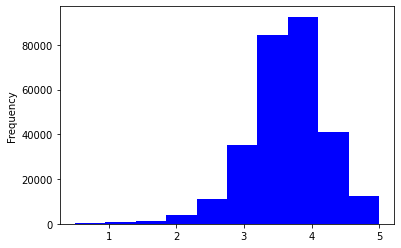

In [ ]:
avg_ratings_user['avg(rating)'].plot(kind='hist',color='blue')
plt.savefig('fig_3.png',dpi=600)

### Movies

In [ ]:
movies_df.show(5,truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [ ]:
#extract release year from movie title
def extract_release_year(title):
  pattern='\((\d{4})\)'
  result=re.search(pattern,title)
  if result:
    year=result.group(1)
    s_pos=result.start()
    title=title[:s_pos-1]
    return (title,year)
  return (title,1970)
extract_year=F.udf(extract_release_year,StructType([StructField('title',StringType(),True),StructField('release_year',StringType(),True)]))
extract_release_year('test (1998)')

('test', '1998')

In [ ]:

#split genres into a list of genres
split_genres=F.udf(lambda x:x.lower().split('|'),ArrayType(StringType()))
movies_df.select('movieId','title',split_genres('genres').alias('genres')).show(5,False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



In [ ]:
movies_df=movies_df.select('movieId',\
                           extract_year('title').title.alias('title'),\
                           extract_year('title').release_year.alias('release_year'),\
                           split_genres('genres').alias('genres'))
movies_df.show(5,truncate=False)

+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_year|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



In [ ]:
#how many categories of movies
spark.sql('select distinct Category from movies lateral view explode(split(genres,"[|]")) as Category order by Category').show()

+------------------+
|          Category|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



In [ ]:
#counts of movies per category
category_count=spark.sql('Select Category, count(movieId) as number from movies lateral view explode(split(genres,"[|]")) as Category group by Category order by number desc').toPandas()


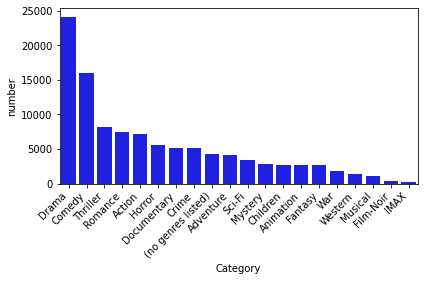

In [ ]:
ax=sns.barplot(x='Category',y='number',data=category_count,color='blue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Links

In [ ]:
links_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [ ]:
#join movies with links to get tmdbid
movies=movies_df.join(links_df,movies_df.movieId==links_df.movieId).\
select(movies_df.movieId,movies_df.title,movies_df.release_year,movies_df.genres,links_df.tmdbId)
movies.show(5,False)

+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_year|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+-------------------------------------------------+------+
only showing top 5 rows



**Get movies poster from TMDb API**

Successfully imported tmdbsimple!


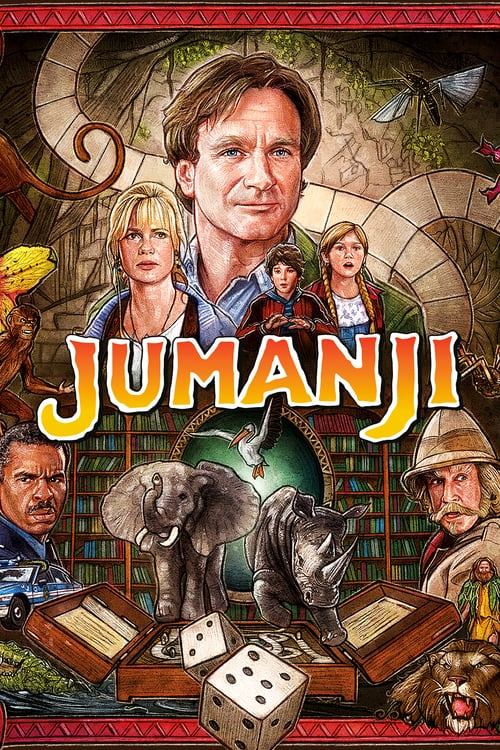

In [ ]:
from IPython.display import Image, HTML, display
from elasticsearch import Elasticsearch,helpers
import tmdbsimple as tmdb

try:
  tmdb.API_KEY='fe2a68da23a562328f579ae29586f111'
  print('Successfully imported tmdbsimple!')
  IMAGE_URL='https://image.tmdb.org/t/p/w500'
  movie_id = movies.filter(movies.movieId==2).collect()[0].tmdbId
  movie_info = tmdb.Movies(movie_id).info()
  movie_poster_url = IMAGE_URL + movie_info['poster_path']
  display(Image(movie_poster_url, width=200))
except Exception:
  print("Cannot import tmdbsimple, no movie posters will be displayed!")

In [ ]:
CONFIG_PATH='./drive/My Drive/Colab Notebooks/'
with open(CONFIG_PATH+'elastic_account.json') as elastic_file:
    ELASTIC_SETTINGS = json.loads(elastic_file.read().strip())

In [ ]:
#initialize a elasticsearch
es = Elasticsearch(
    cloud_id=ELASTIC_SETTINGS["cloud_id"],
    http_auth=(ELASTIC_SETTINGS["user"], ELASTIC_SETTINGS["password"]),
)
es.info()

{'cluster_name': 'ea05703d394d446888d4c1a67a03d8cd',
 'cluster_uuid': 'kLbKDtHBSBiYw9djxtbkBA',
 'name': 'instance-0000000001',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2020-06-14T19:35:50.234439Z',
  'build_flavor': 'default',
  'build_hash': '757314695644ea9a1dc2fecd26d1a43856725e65',
  'build_snapshot': False,
  'build_type': 'docker',
  'lucene_version': '8.5.1',
  'minimum_index_compatibility_version': '6.0.0-beta1',
  'minimum_wire_compatibility_version': '6.8.0',
  'number': '7.8.0'}}

In [ ]:
if es.indices.exists(index='users'):
  es.indices.delete(index='users')
if es.indices.exists(index='movies'):
  es.indices.delete(index='movies')
if es.indices.exists(index='ratings'):
  es.indices.delete(index='ratings')

In [ ]:
user_index = {
    "mappings": {
            # this mapping definition sets up the metadata fields for the users
            "properties": {
                "userId": {
                    "type": "integer"
                },
              "user_vector":{"type": "dense_vector",
                                "dims": 10
                                }
            }
        }
}
movie_index={
    "mappings":{
            # this mapping definition sets up the metadata fields for the movies
            "properties": {
                "movieId": {
                    "type": "integer"
                },
                "tmdbId": {
                    "type": "keyword"
                },
                "genres": {
                    "type": "keyword"
                },
                "release_year": {
                    "type": "date",
                    "format": "year"
                },
                "title":{
                    "type":"keyword"
                },
                "movie_vector":{"type": "dense_vector",
                                "dims": 10
                                }
        }   
    }
}
rating_index={
     "mappings": {
          "properties": {
                "timestamp": {
                    "type": "date"
                },
                "userId": {
                    "type": "integer"
                },
                "movieId": {
                    "type": "integer"
                },
                "rating": {
                    "type": "double"
                }
            }  
        }
}

# create index with the settings and mappings above
es.indices.create(index="users", body=user_index)
es.indices.create(index="movies", body=movie_index)
es.indices.create(index="ratings", body=rating_index)

{'acknowledged': True, 'index': 'ratings', 'shards_acknowledged': True}

## Model training using Spark ALS 


In [ ]:
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [ ]:
#drop timestamp because it's not needed
movie_ratings=ratings_df.drop('timestamp')

In [ ]:
movie_ratings.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    307|   3.5|
|     1|    481|   3.5|
|     1|   1091|   1.5|
|     1|   1257|   4.5|
|     1|   1449|   4.5|
+------+-------+------+
only showing top 5 rows



In [ ]:

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS,ALSModel
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
#Create test and train set
(training,val,test)=movie_ratings.randomSplit([0.6,0.2,0.2], seed = 65)
als_model=ALS(userCol='userId', itemCol='movieId', ratingCol='rating',coldStartStrategy='drop')



In [ ]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [ ]:
def tune_ALS(model,max_iter,ranks,reg_params,training,validation,evaluator):
  min_error=float('inf')
  best_model=None
  best_rank=-1
  best_regularization=0
  error_list=[]
  for rank in ranks:
    for reg in reg_params:
      als=model.setMaxIter(max_iter).setRank(rank).setRegParam(reg)
      trained_model=als.fit(training)
      predictions=trained_model.transform(validation)
      rmse=evaluator.evaluate(predictions)
      error_list.append((rank,reg,rmse))
      print('{} latent factors and regularization is {}: '.format(rank,reg))
      print('RMSE is {}'.format(rmse))
      if rmse<min_error:
        min_error=rmse
        best_model=trained_model
        best_rank=rank
        best_regularization=reg 
  print('**Best model**')
  print( 'rank is {}\n regularization is {}\n rmse is {}'.format(best_rank,best_regularization,min_error))
  return best_model,error_list


In [ ]:
ranks=[10]
regs=np.logspace(-3,0,6)

In [ ]:
best_model,error_list=tune_ALS(als_model,10,ranks,regs,training,val,evaluator)

10 latent factors and regularization is 0.001: 
RMSE is 0.8897170694402308
10 latent factors and regularization is 0.003981071705534973: 
RMSE is 0.8701824783212757
10 latent factors and regularization is 0.015848931924611134: 
RMSE is 0.8467973466599669
10 latent factors and regularization is 0.0630957344480193: 
RMSE is 0.81368342015377
10 latent factors and regularization is 0.25118864315095796: 
RMSE is 0.8889433076535797
10 latent factors and regularization is 1.0: 
RMSE is 1.3279851990413667
**Best model**
rank is 10
 regularization is 0.0630957344480193
 rmse is 0.81368342015377


In [ ]:
param_errors=pd.DataFrame(error_list,columns=['rank','reg','rmse'])

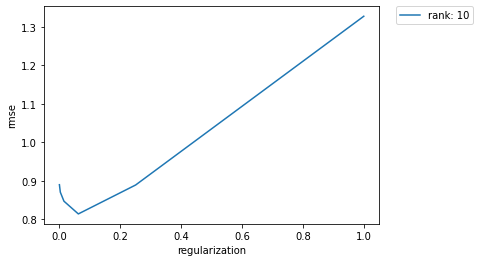

In [ ]:
for rank in ranks:
  plt.plot(param_errors[param_errors['rank']==rank]['reg'],param_errors[param_errors['rank']==rank]['rmse'],label='rank: {}'.format(rank))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('regularization')
plt.ylabel('rmse')
plt.show()

In [ ]:
#Generate predictions and evaluate using RMSE
predictions=best_model.transform(test)
rmse = evaluator.evaluate(predictions)

In [ ]:
#Print evaluation metrics and model parameters
# 这个没有打印出正确的 rank，maxiter,regprarm， 不知道为什么
print ("RMSE = "+str(rmse))
print ("**Best Model**")
print (" Rank:"+str(best_model._java_obj.parent().getRank())), 
print (" MaxIter:"+str(best_model._java_obj.parent().getMaxIter())), 
print (" RegParam:"+str(best_model._java_obj.parent().getRegParam()))

RMSE = 0.8140890417776232
**Best Model**
 Rank:10
 MaxIter:10
 RegParam:1.0


In [ ]:
#save trained model to my google drive to be used later
best_model.write().overwrite().save('/content/drive/My Drive/Movie_Recommendation_model')

## Model apply

In [ ]:
all_data=best_model.transform(movie_ratings)
rmse = evaluator.evaluate(all_data)
print ("RMSE = "+str(rmse))
all_data.cache()

RMSE = 0.7600245991475985


DataFrame[userId: int, movieId: int, rating: double, prediction: float]

In [ ]:
all_data.show(5)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|107339|    148|   4.0| 3.4424815|
| 93112|    148|   3.0|   2.74842|
|106148|    148|   2.5|  2.955136|
|234926|    148|   4.0| 3.0260634|
|253535|    148|   4.0| 3.1727629|
+------+-------+------+----------+
only showing top 5 rows



In [ ]:
all_data.join(movies_df,on='movieId').show()

+-------+------+------+----------+--------------------+------------+-------+
|movieId|userId|rating|prediction|               title|release_year| genres|
+-------+------+------+----------+--------------------+------------+-------+
|    148|107339|   4.0| 3.4424815|Awfully Big Adven...|        1995|[drama]|
|    148| 93112|   3.0|   2.74842|Awfully Big Adven...|        1995|[drama]|
|    148|106148|   2.5|  2.955136|Awfully Big Adven...|        1995|[drama]|
|    148|234926|   4.0| 3.0260634|Awfully Big Adven...|        1995|[drama]|
|    148|253535|   4.0| 3.1727629|Awfully Big Adven...|        1995|[drama]|
|    148| 50155|   3.0| 3.1293845|Awfully Big Adven...|        1995|[drama]|
|    148| 65991|   4.0| 3.2999914|Awfully Big Adven...|        1995|[drama]|
|    148|146376|   5.0|  3.940832|Awfully Big Adven...|        1995|[drama]|
|    148|207939|   3.0| 2.7087412|Awfully Big Adven...|        1995|[drama]|
|    148| 41788|   3.0| 2.8329403|Awfully Big Adven...|        1995|[drama]|

## Recommend movie to users

In [ ]:
from pyspark.ml.recommendation import ALS,ALSModel
best_model=ALSModel.load('/content/drive/My Drive/Movie_Recommendation_model')

In [ ]:
user_recs=best_model.recommendForAllUsers(10)

In [ ]:
user_recs.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- movieId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
#save recommendations
user_recs.write.save(('/content/drive/My Drive/Recommendations'))

## Reuse saved recommendation data 

In [ ]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()


In [ ]:
user_recs=spark.read.load('/content/drive/My Drive/Recommendations')

In [ ]:
user_recs.show(5)

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   145|[[177209, 6.40186...|
|   200|[[151989, 5.37149...|
|   272|[[151989, 6.93882...|
|   376|[[177209, 5.06332...|
|   488|[[101862, 5.62039...|
+------+--------------------+
only showing top 5 rows



In [ ]:
user_recs.filter(user_recs.userId==575).show(5,False)

+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                      |
+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|575   |[[87511, 6.193467], [183845, 5.9482636], [149306, 5.903204], [62206, 5.8123064], [103032, 5.810453], [66811, 5.76702], [117907, 5.6698956], [74141, 5.614199], [161662, 5.519294], [79236, 5.458666]]|
+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
user_recs_kdf=user_recs.to_koalas()

In [ ]:
user_recs_kdf.head()

,userId,recommendations
0,145,"[(177209, 6.4018635749816895), (121919, 6.3069..."
1,200,"[(151989, 5.371495246887207), (193369, 5.06946..."
2,272,"[(151989, 6.93882417678833), (177209, 6.540125..."
3,376,"[(177209, 5.063328742980957), (151989, 4.87840..."
4,488,"[(101862, 5.62039852142334), (151989, 5.592012..."


In [ ]:
movies_kdf=movies.to_koalas()

In [ ]:
movies_kdf.loc[movies_kdf.release_year==str(2018)].head(10)

,movieId,title,release_year,genres,tmdbId
27558,122910,Captain Marvel,2018,"[action, adventure, sci-fi]",299537
27559,122912,Avengers: Infinity War - Part I,2018,"[action, adventure, sci-fi]",299536
32528,135448,Avatar 4,2018,"[action, adventure, fantasy, sci-fi]",216527
35904,143347,Aquaman,2018,"[action, fantasy, sci-fi]",297802
53148,182369,Journey's End,2018,[war],438259
53311,182715,Annihilation,2018,"[adventure, mystery, sci-fi, thriller]",300668
53369,182835,The 15:17 to Paris,2018,"[drama, thriller]",453201
53450,183011,The Commuter,2018,"[crime, drama, mystery, thriller]",399035
53468,183055,The Beyond,2018,"[horror, sci-fi]",449575
53503,183155,Lean on Pete,2018,"[adventure, drama]",407890


In [ ]:
rec_movies=[]

for item in user_recs_kdf.loc[user_recs_kdf.userId==10].values[0][1]:
  movie_id=item[0]
  score=item[1]
  rec_movies.append((movie_id,score))
recs_kdf=ks.DataFrame(rec_movies,columns=['movieId','score'])
recs_kdf.merge(movies_kdf,on='movieId')

,movieId,score,title,release_year,genres,tmdbId
0,155923,5.557970,Sing,1989,[(no genres listed)],63701
1,166812,5.464772,Seeing Red: Stories of American Communists,1983,[(no genres listed)],136058
2,177209,5.821263,Acı Aşk,2009,[drama],35173
3,192089,5.678817,"National Theatre Live: One Man, Two Guvnors",2011,[comedy],400444
4,183947,5.547582,NOFX Backstage Passport 2,1970,[(no genres listed)],378790
5,101862,5.491183,50 Children: The Rescue Mission of Mr. And Mrs...,2013,[documentary],202132
6,161662,5.533348,Pufnstuf,1970,"[children, comedy, fantasy]",63859
7,187873,5.557970,Real Boy,2016,[documentary],395499
8,122222,5.613120,The Bride Goes Wild,1948,"[comedy, romance]",107999
9,151989,5.808688,The Thorn,1971,[comedy],215797


In [ ]:
def get_poster_url(tmdb_id):
  IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
  try:
    import tmdbsimple as tmdb
    from tmdbsimple import APIKeyError
    try:
      movie = tmdb.Movies(tmdb_id).info()
      poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
      return poster_url
    except APIKeyError as ae:
      return "KEY_ERR"
  except Exception as me:
    return "NA"

def get_movie_recs(user_recs_kdf,user_id):
  rec_movies=[]
  for item in user_recs_kdf.loc[user_recs_kdf.userId==user_id].values[0][1]:
    movie_id=item[0]
    score=item[1]
    rec_movies.append((movie_id,score))

  recs_kdf=ks.DataFrame(rec_movies,columns=['movieId','score'])
  recs_kdf=recs_kdf.merge(movies_kdf,on='movieId')
  return recs_kdf

def display_movie_recs(user_recs_kdf,user_id):
  rec_movies=get_movie_recs(user_recs_kdf,user_id)
  user_movies=ratings_df.filter(ratings_df.userId==user_id).orderBy('rating',ascending=False).limit(5).to_koalas()
  user_movies=user_movies.merge(movies_kdf,on='movieId')    
  # display the movies that this user has rated highly
  display(HTML("<h2>Get recommended movies for user id %s</h2>" % user_id))
  display(HTML("<h4>The user has rated the following movies highly:</h4>"))
  user_html = "<table border=0>"
  i = 0
  for _,movie in user_movies.iterrows():
      movie_im_url = get_poster_url(movie['tmdbId'])
      movie_title = movie['title']
      user_html += "<td><h5>%s</h5><img src=%s width=150></img></td>" % (movie_title, movie_im_url)
      i += 1
      if i % 5 == 0:
          user_html += "</tr><tr>"
  user_html += "</tr></table>"
  display(HTML(user_html))
  # now display the recommended movies for the user
  display(HTML("<br>"))
  display(HTML("<h2>Recommended movies:</h2>"))
  rec_html = "<table border=0>"
  i = 0
  for _,rec in rec_movies.iterrows():
      r_im_url = get_poster_url(rec['tmdbId'])
      r_score = rec['score']
      r_title = rec['title']
      rec_html +="<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
      i += 1
      if i % 5 == 0:
          rec_html += "</tr><tr>"
  rec_html += "</tr></table>"
  display(HTML(rec_html))



In [ ]:
display_movie_recs(user_recs_kdf,420)

The Good Mother,4.667,A Kind of America 2,4.627,A Very Old Story,4.669,"Hatful of Rain, A",4.529,The Thorn,4.595


## Find similar movies using movie factors

In [ ]:
movie_factors_kdf=best_model.itemFactors.to_koalas()

In [ ]:
movie_factors_kdf.head()

,id,features
0,1,"[-0.5792995691299438, 0.49500083923339844, -0...."
1,11,"[-0.270975261926651, 0.6689077615737915, -0.16..."
2,21,"[-0.348054975271225, 0.2774294316768646, -0.05..."
3,31,"[-0.30289751291275024, 0.9731132984161377, -0...."
4,41,"[-0.29315149784088135, 0.37227651476860046, 0...."


In [ ]:
def find_similar_movies(features,movie_id):
  try:
    target_id_feature=movie_factors_kdf.loc[movie_factors_kdf.id==movie_id].features.to_numpy()[0]
  except:
    return 'There is no movie with id '+str(movie_id)
  similarities=[]
  
  for feature in movie_factors_kdf['features'].to_numpy():
    similarity=np.dot(target_id_feature,feature)/(np.linalg.norm(target_id_feature)*np.linalg.norm(feature))
    similarities.append(similarity)

  similarity_kdf=ks.DataFrame({'similarity':similarities},index=movie_factors_kdf.id.to_numpy())
  top_11=similarity_kdf.sort_values(by=['similarity'],ascending=False).head(11)
  merged_kdf=top_11.merge(movies_kdf,left_index=True,right_on='movieId',how='inner')
  merged_kdf.sort_values(by=['similarity'],ascending=False,inplace=True)
  merged_kdf.reset_index(inplace=True)
  return merged_kdf

def display_similar(features,movie_id):
  """
  Display query movie, together with similar movies and similarity scores, in a table
  """
  similar_movies = find_similar_movies(features,movie_id)
  movie=similar_movies.iloc[0]
  recs=similar_movies.iloc[1:]
  q_im_url = get_poster_url(movie['tmdbId'])
  if q_im_url == "NA":
      display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
  if q_im_url == "KEY_ERR":
      display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
      
  display(HTML("<h2>Get similar movies for:</h2>"))
  display(HTML("<h4>%s</h4>" % movie['title']))
  if q_im_url != "NA":
      display(Image(q_im_url, width=200))
  display(HTML("<br>"))
  display(HTML("<h2>People who liked this movie also liked these:</h2>"))
  sim_html = "<table border=0>"
  i = 0
  for _,rec in recs.iterrows():
    r_im_url = get_poster_url(rec['tmdbId'])
    r_score = rec['similarity']
    r_title = rec['title']
    sim_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
    i += 1
    if i % 5 == 0:
      sim_html += "</tr><tr>"
  sim_html += "</tr></table>"
  display(HTML(sim_html))

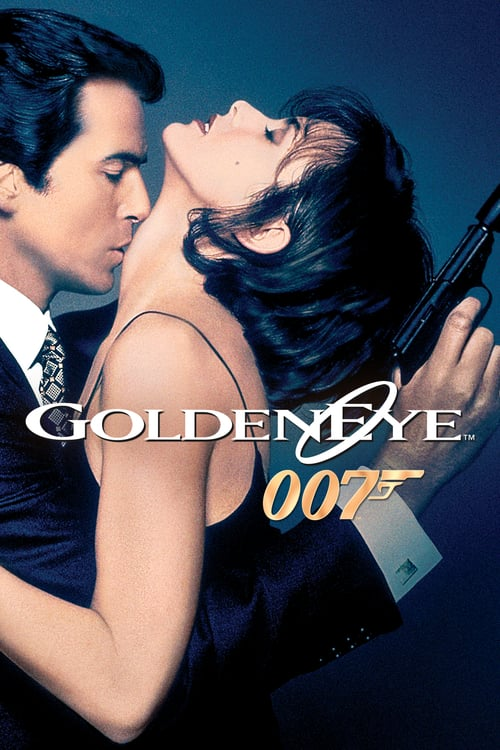

Maverick,0.977,Stargate,0.975,Tombstone,0.975,Terminator 2: Judgment Day,0.975,"Rock, The",0.974


In [ ]:
display_similar(features=movie_factors_kdf.features,movie_id=10)
